# Downloading ArcticDEM/REMA mosaics and calculating terrain parameters

In [1]:
import os

import pdemtools as pdt

As well as `pdemtools`, we will also make use of `matplotlib` to plot our results in this notebook.

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.sans-serif'] = "Arial"

# %matplotlib widget

## Load mosiac

To load mosaics from the PGC AWS bucket, we can make use of pDEMtools' `load.mosaic()` function.

All we need is the bounds of our area of interest. This can be a tuple (in the format `[xmin, ymin, xmax, ymax]`) or a `shapely` geometry. Note that pDEMtools currently only accepts bounds in the same format as the ArcticDEM/REMA datasets themselves: that is say, the Polar Stereographic projections (EPSG:3413 for the north and EPSG:3031 for the south).

For this example, let's set the bounds to take a look at Helheim Glacier:

In [3]:
bounds = (295000,-2585000,315000,-2567000)


Now we can use the `pdemtools.mosaic()` function, specificying the dataset (`'arcicdem'` or `'rema'`), resolution (which can be either `2`, `10`, or `32` metres), and the aforementioned bounding box. Note that, at this step, we are downloading the data from the AWS bucket, so 2 m resolution mosaics may take a while to download. Let's download the 32 m mosaic for now:

In [4]:
%%time
dem = pdt.load.mosaic(
    dataset='arcticdem',  # must be `arcticdem` or `rema`
    resolution=32,        # must be 2, 10, or 32
    bounds=bounds,        # (xmin, ymin, xmax, ymax) or shapely geometry
    version='v4.1',       # optional: desired version (defaults to most recent)
)

CPU times: user 203 ms, sys: 45.7 ms, total: 249 ms
Wall time: 6.52 s


pDEMtool functions return [`rioxarray`-compatible `xarray` DataArrays](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-rio-accessors), meaning you can take advantage of all relevant functionality, such as saving:

In [5]:
if not os.path.exists('example_data'):
    os.mkdir('example_data')

dem.rio.to_raster(f'example_data/helheim_arcticdem_mosaic_32m.tif', compress='ZSTD', predictor=3, zlevel=1)

Or plotting:

Text(0.5, 1.0, '32 m ArcticDEM mosaic of Helheim Glacier')

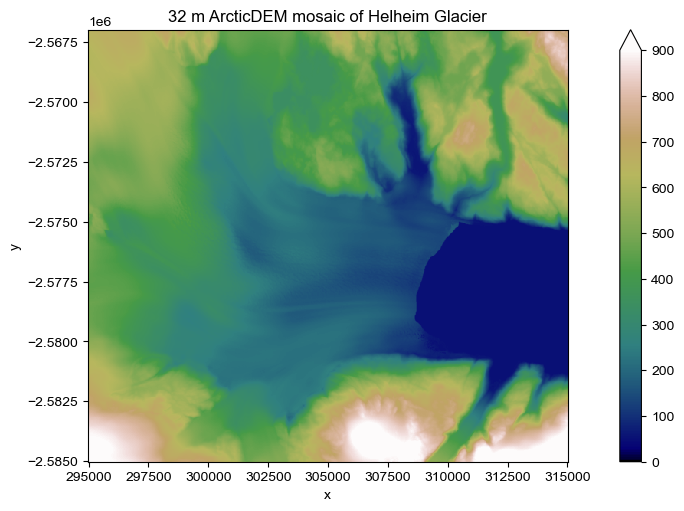

In [6]:
plt.close()
fig, ax = plt.subplots(figsize=(7,5))

dem.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=900)

ax.set_aspect('equal')
ax.set_title('32 m ArcticDEM mosaic of Helheim Glacier')

## Postprocessing

pDEMtools introduces a handy [xarray accessor](https://docs.xarray.dev/en/stable/internals/extending-xarray.html) for performing preliminary preprocessing and assessment. These aren't intended to be as full-featured as some other excellent community tools, such as [xdem](https://xdem.readthedocs.io/en/stable/) or [richdem](https://github.com/r-barnes/richdem), but it is hoped that they are _specific_ to the sort of uses that ArcticDEM and REMA users might want (e.g. a focus on ice sheet and cryosphere work), as well as the particular _strengths_ of ArcticDEM and REMA datasets (high-resolution and multitemporal).

### Geoid Correction

By taking advantage of a local copy of the Greenland or Antarctica BedMachine, the `data` module's `geoid_from_bedmachine()` function can be used to quickly extract a valid geoid, reprojected and resampled to match the study area:

In [7]:
bedmachine_fpath = '.../BedMachineGreenland-v5.nc'

geoid = pdt.data.geoid_from_bedmachine(bedmachine_fpath, dem)

If you wish to use a different geoid (for instance, you are interested in a region outside of Greenland or Antarctica) you can also use your own geoid, loaded via xarray. To aid with this, a `geoid_from_raster()` function is also included in the `data` module, accepting a filepath to a `rioxarray.open_rasterio()`-compatible file type.

We can then correct the DEM using geoid and the `.pdt.geoid_correct()` function. 

In [8]:
dem_geoidcor = dem.pdt.geoid_correct(geoid)

### Sea Level Filtering

We can also filter out sea level from geoid-corrected DEMs, adapting the method of Shiggins _et al._ (2023) to detect sea level. 

In this workflow, sea-level is defined as the modal 0.25 m histogram bin between +10 and -10 metres above the geoid. If there is not at least 1 km<sup>2</sup> of surface between these values, then the DEM is considered to have no signficant ocean surface. DEM surface is masked as ocean where the surface is within 5 m of the detected sea level.

All of these values can be modified as input variables, but to stick with the defaults we can leave as-is:

In [9]:
dem_masked = dem_geoidcor.pdt.mask_ocean(near_sealevel_thresh_m=5)

Text(0.5, 1.0, 'Helheim Glacier (geoid-corrected and ocean-masked')

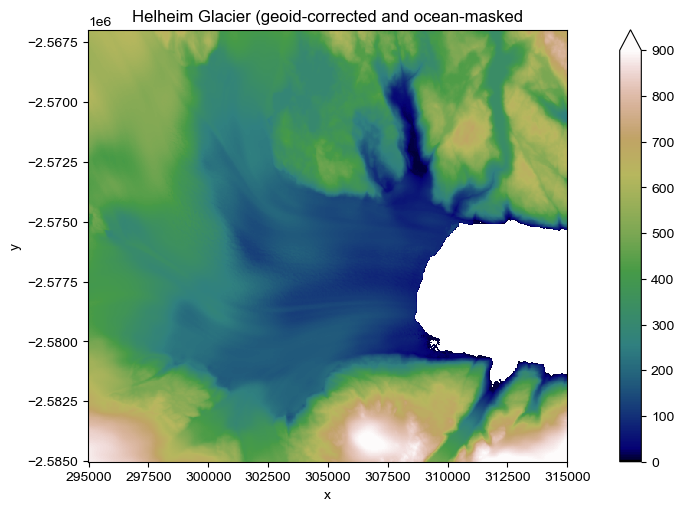

In [10]:
plt.close()
fig, ax = plt.subplots(figsize=(7,5))

dem_masked.plot(ax=ax, cmap='gist_earth', vmin=0, vmax=900)

ax.set_aspect('equal')
ax.set_title('Helheim Glacier (geoid-corrected and ocean-masked')

Although it is not the case for the new (v.4.1) ArcticDEM mosaic, when examining individual strips or older mosaics, icebergs will remain unmasked. This is reflective of the original purpose of the Shiggins _et al._ (2023) method, which was to identify icebergs! 

If desired, we can resolve this by filtering out smaller groups of pixels. pDEMtools offers this function as part of the `.pdt.mask_icebergs()` function, which wraps the `cv2.connectedComponentsWithStats` function to filter out contiguous areas beneath a provided area threshold (defaults to 1e<sup>6</sup> m<sup>2</sup>, i.e. 1 km<sup>2</sup>)

In [11]:
dem_masked = dem_masked.pdt.mask_icebergs(area_thresh_m2=1e6)

### Terrain Parameters

The full list of terrain variables you can calculate with pDEMtools is as follows:

In [12]:
variable_list = [
    'slope', 
    'aspect', 
    'hillshade',
    "horizontal_curvature",
    "vertical_curvature",
    "mean_curvature",
    "gaussian_curvature",
    "unsphericity_curvature",
    "minimal_curvature",
    "maximal_curvature",
]

The geomorphometric parameters used to calculate these variables ($\frac{\partial z}{\partial x}$, $\frac{\partial z}{\partial y}$, $\frac{\partial^2 z}{\partial x^2}$, $\frac{\partial^2 z}{\partial y^2}$, $\frac{\partial^2 z}{\partial x \partial y}$) are derived following Florinsky (2009), as opposed to more common methods (e.g. Horn, 1981, or Zevenbergen & Thorne, 1987). 

The motivation here is that Florinsky (2009) computes partial derivatives of elevation based on fitting a third-order polynomial, by the least-squares approach, to a 5$\times$5 window, as opposed to the more common 3$\times$3 window. This is more appropriate for high-resolution DEMs: curvature over a 10 m window for the 2 m resolution ArcticDEM/REMA strips will lead to a local deonising effect that limits the impact of noise.

After contructing the list of variabels you would like to calculate, you can request them from the `pdt.terrain()` accessor function. Note there are some bonus settings regarding the hillshade, such as the z factor, using a multidirectional algorithm, or selecting the azimuth/altitude.

In [13]:
terrain = dem_masked.pdt.terrain(variable_list, hillshade_z_factor=2, hillshade_multidirectional=True)

If you would rather calculate these variables using a more traditional method, you can add `method = 'ZevenbergThorne'` to the `.pdt.terrain()` function to calculate following Zevenbergen and Thorne (1987).

The output of the `.pdt.terrain()` function, here the `terrain` variable, is a (rio)xarray DataSet containing all the selected variables, as well as the original DEM:

In [14]:
terrain

<xarray.Dataset>
Dimensions:                 (x: 626, y: 564, band: 1)
Coordinates:
  * x                       (x) float64 2.95e+05 2.95e+05 ... 3.15e+05 3.15e+05
  * y                       (y) float64 -2.567e+06 -2.567e+06 ... -2.585e+06
  * band                    (band) int64 1
    spatial_ref             int64 0
    mapping                 int64 0
Data variables:
    dem                     (band, y, x) float32 602.5 603.1 ... 936.9 937.1
    slope                   (band, y, x) float32 nan nan nan nan ... nan nan nan
    aspect                  (band, y, x) float32 nan nan nan nan ... nan nan nan
    hillshade               (band, y, x) float64 nan nan nan nan ... nan nan nan
    horizontal_curvature    (band, y, x) float32 nan nan nan nan ... nan nan nan
    vertical_curvature      (band, y, x) float32 nan nan nan nan ... nan nan nan
    mean_curvature          (band, y, x) float32 nan nan nan nan ... nan nan nan
    gaussian_curvature      (band, y, x) float32 nan nan nan nan ... nan nan nan
    unsphericity_curvature  (band, y, x) float32 nan nan nan nan ... nan nan nan
    minimal_curvature       (band, y, x) float32 nan nan nan nan ... nan nan nan
    maximal_curvature       (band, y, x) float32 nan nan nan nan ... nan nan nan

Note that the tools do not account for edge effects, which instead resolve to `nan` values. 

We can now plot as follows:

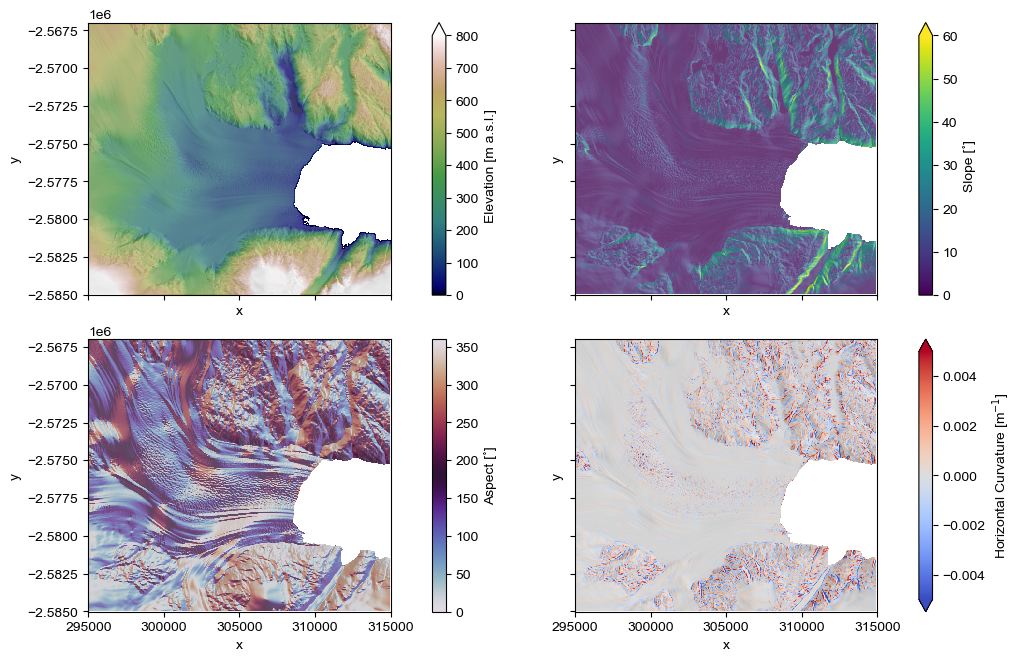

In [15]:
plt.close()
fig, axes = plt.subplots(figsize=(10,6.5), ncols=2, nrows=2, sharex=True, sharey=True)

ax=axes[0,0]
terrain.dem.plot(cmap='gist_earth', ax=ax, vmin=0, vmax=800, cbar_kwargs={'label': 'Elevation [m a.s.l.]'})

ax=axes[0,1]
terrain.slope.plot(cmap='viridis', ax=ax, vmin=0, vmax=60, cbar_kwargs={'label': 'Slope [˚]'})

ax=axes[1,0]
terrain.aspect.plot(cmap='twilight', ax=ax, vmin=0, vmax=360, cbar_kwargs={'label': 'Aspect [˚]'})

ax=axes[1,1]
vrange=0.005
terrain.horizontal_curvature.plot(cmap='coolwarm', ax=ax, vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'Horizontal Curvature [m$^{-1}$]'})

for ax in axes.ravel():
    ax.set_aspect('equal')
    terrain.hillshade.plot(ax=ax, cmap='Greys_r', alpha=.3, add_colorbar=False)
    ax.set_title(None)

plt.savefig('../images/example_mosaic_terrain.jpg', dpi=300)